In [1]:
# Disable TensorFlow debugging info and warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 2: Info and warnings not displayed 

In [2]:
import tensorflow as tf
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
import pathlib
import tqdm
import annotation, misc, hyspec_cnn, hyspec_io

In [3]:
# Disable GPUs
tf.config.set_visible_devices([], 'GPU')
visible_devices = tf.config.get_visible_devices()
for device in visible_devices:
    assert device.device_type != 'GPU'

In [4]:
# Parameters
train_frac = 0.7
train_classes_to_merge = {6:2,7:4,8:5}
val_classes_to_skip = [6,7,8]

In [5]:
# Paths
tiles_dir = pathlib.Path('/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/4b_Rad_Georef_SGC_Tiles/TrainingAndValidationDatasets')
json_file = '/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/4b_Rad_Georef_SGC_Tiles/tile_classes.json'

In [6]:
# Read JSON with class names and labels
class_dict = annotation.read_class_dict(json_file)

In [11]:
# Load and merge datasets
dataset_dirs = [x for x in tiles_dir.glob('*/') if x.is_dir()]
# datasets = [tf.data.experimental.load(str(ds_dir)) for ds_dir in dataset_dirs]
merged_dataset = tf.data.experimental.load(str(dataset_dirs[0]))
for ds_dir in dataset_dirs[1:]:
    merged_dataset = merged_dataset.concatenate(tf.data.experimental.load(str(ds_dir)))

In [12]:
# Check how many tiles there are
n_tiles = merged_dataset.cardinality().numpy()
print(n_tiles)

459


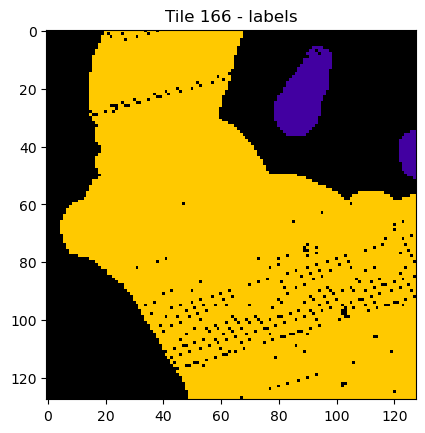

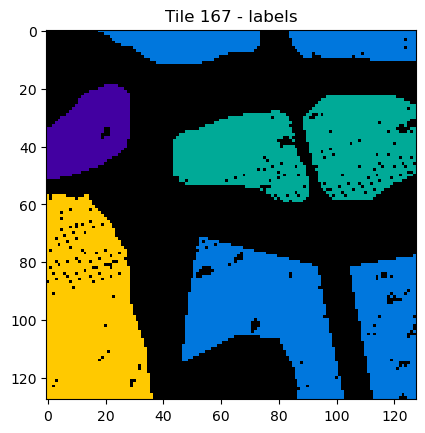

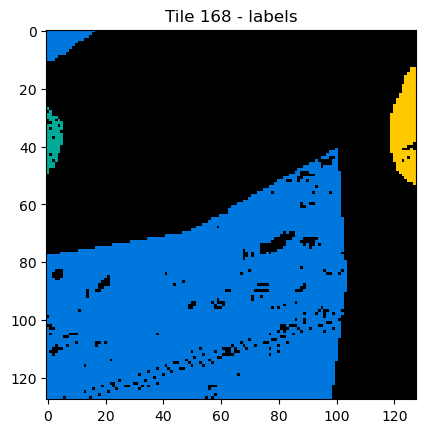

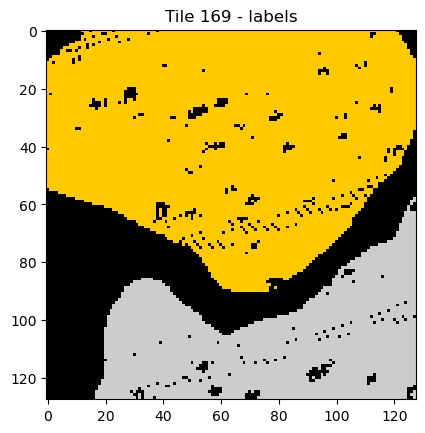

In [66]:
# Show some of the label tiles:
index = 166
for image,label in merged_dataset.skip(index).take(4).prefetch(1):
    plt.imshow(label,vmin=0,vmax=8,cmap='nipy_spectral',interpolation='none')
    plt.title(f'Tile {index} - labels')
    plt.show()
    index+=1

In [37]:
def add_background_zero_weight(image, labels):    
    label_mask = tf.greater(labels,0)
    zeros = tf.zeros_like(labels,dtype=tf.float32)
    ones = tf.ones_like(labels,dtype=tf.float32)
    
    # "Multiplex" using label mask, ones for annotated pixels, zeros for background
    sample_weights = tf.where(label_mask, ones, zeros)  # 

    return image, labels, sample_weights

In [60]:
def merge_nft_labels(image,labels):
    merged_label_indices = tf.constant([0,1,2,3,4,5,2,4,5])  # 6 = seagrass, 7 = rockweed, 8 = other
    new_labels = tf.gather(merged_label_indices,tf.cast(labels,tf.int32))
    return image, new_labels

In [68]:
def remove_nft_labels(image,labels):
    merged_label_indices = tf.constant([0,1,2,3,4,5,0,0,0])  # 6 = seagrass, 7 = rockweed, 8 = other
    new_labels = tf.gather(merged_label_indices,tf.cast(labels,tf.int32))
    return image, new_labels

In [70]:
dataset_ngt_labels_merged = merged_dataset.map(merge_nft_labels)
dataset_ngt_labels_removed = merged_dataset.map(remove_nft_labels)

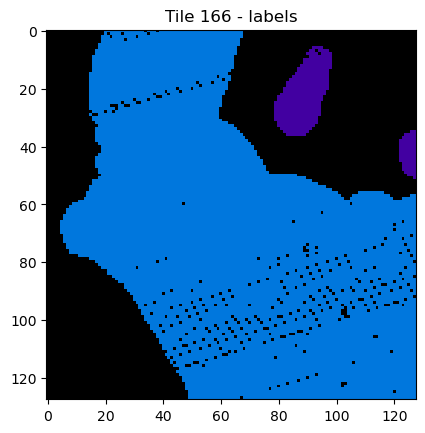

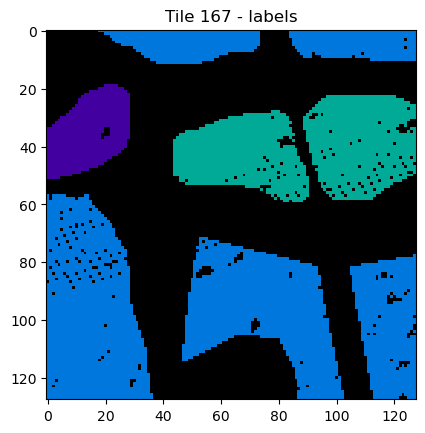

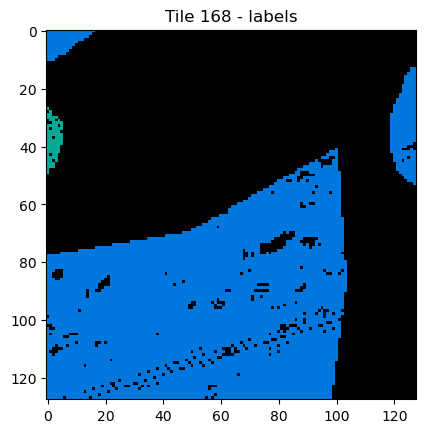

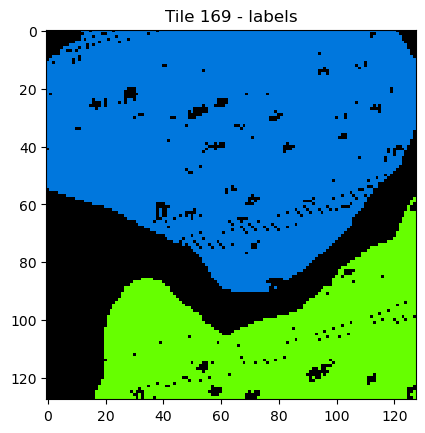

In [71]:
# Show some of the label tiles after merging labels
index = 166
for image,label in dataset_ngt_labels_merged.skip(index).take(4).prefetch(1):
    plt.imshow(label,vmin=0,vmax=8,cmap='nipy_spectral',interpolation='none')
    plt.title(f'Tile {index} - labels')
    plt.show()
    index+=1

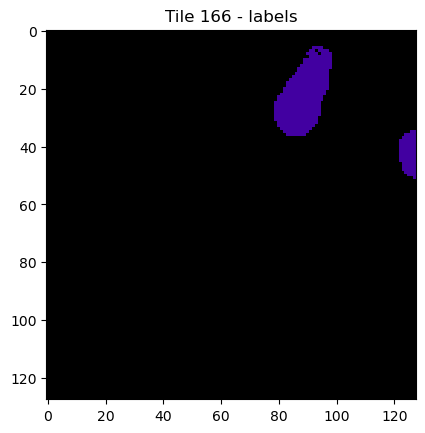

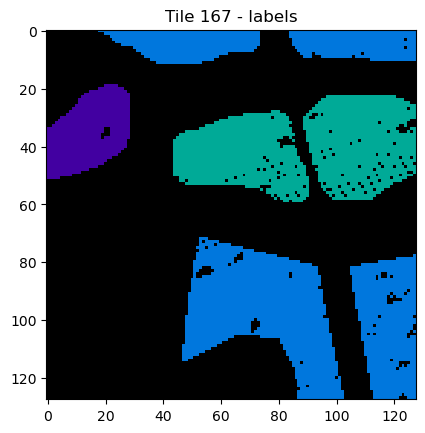

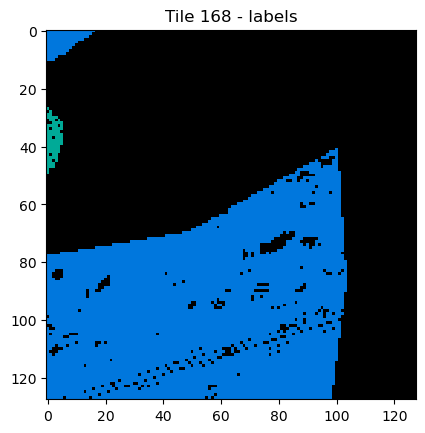

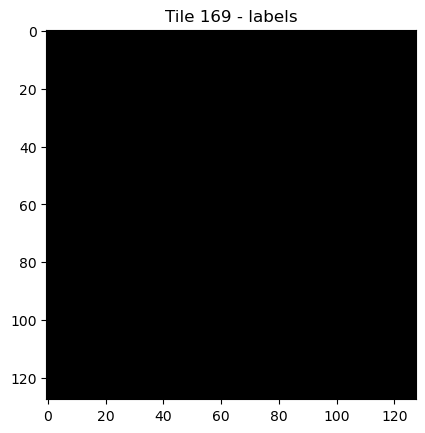

In [72]:
# Show some of the label tiles after removing labels
index = 166
for image,label in dataset_ngt_labels_removed.skip(index).take(4).prefetch(1):
    plt.imshow(label,vmin=0,vmax=8,cmap='nipy_spectral',interpolation='none')
    plt.title(f'Tile {index} - labels')
    plt.show()
    index+=1

In [73]:
dataset_with_weights = dataset_ngt_labels_merged.map(add_background_zero_weight)

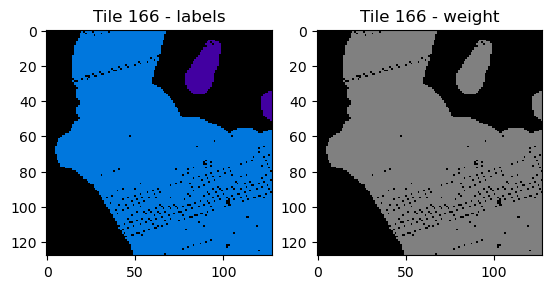

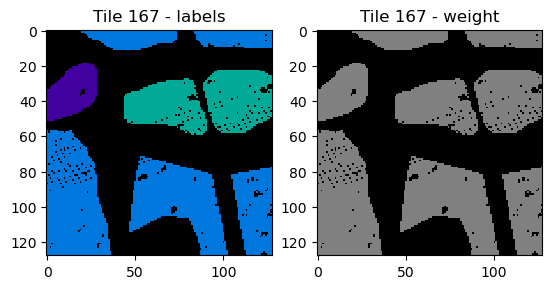

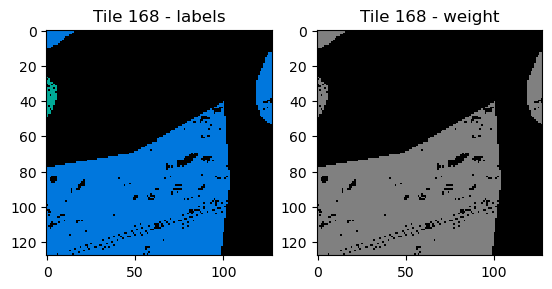

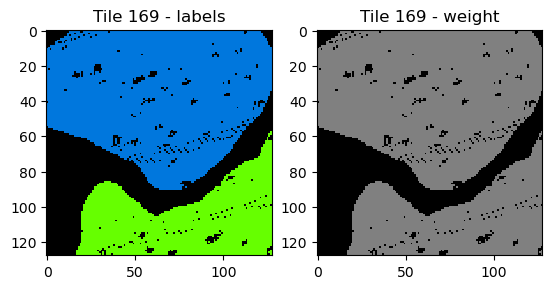

In [75]:
# Show some of the label tiles:
index = 166
for image,label,weight in dataset_with_weights.skip(index).take(4).prefetch(1):
    fig,ax = plt.subplots(ncols=2)
    ax[0].imshow(label,vmin=0,vmax=8,cmap='nipy_spectral',interpolation='none')
    ax[0].title.set_text(f'Tile {index} - labels')
    ax[1].imshow(weight,vmin=0,vmax=2,cmap='gray',interpolation='none')
    ax[1].title.set_text(f'Tile {index} - weight')
    plt.show()
    index+=1